### Import libraries

In [145]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [146]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.13.0


In [147]:
# Import some other useful libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

### Import and visualize data

In [148]:
data = np.load('public_data.npz',allow_pickle=True)
lst = data.files
images = data[lst[0]]
labels = data[lst[1]]

# Convert values in data to int
images = images.astype(int)

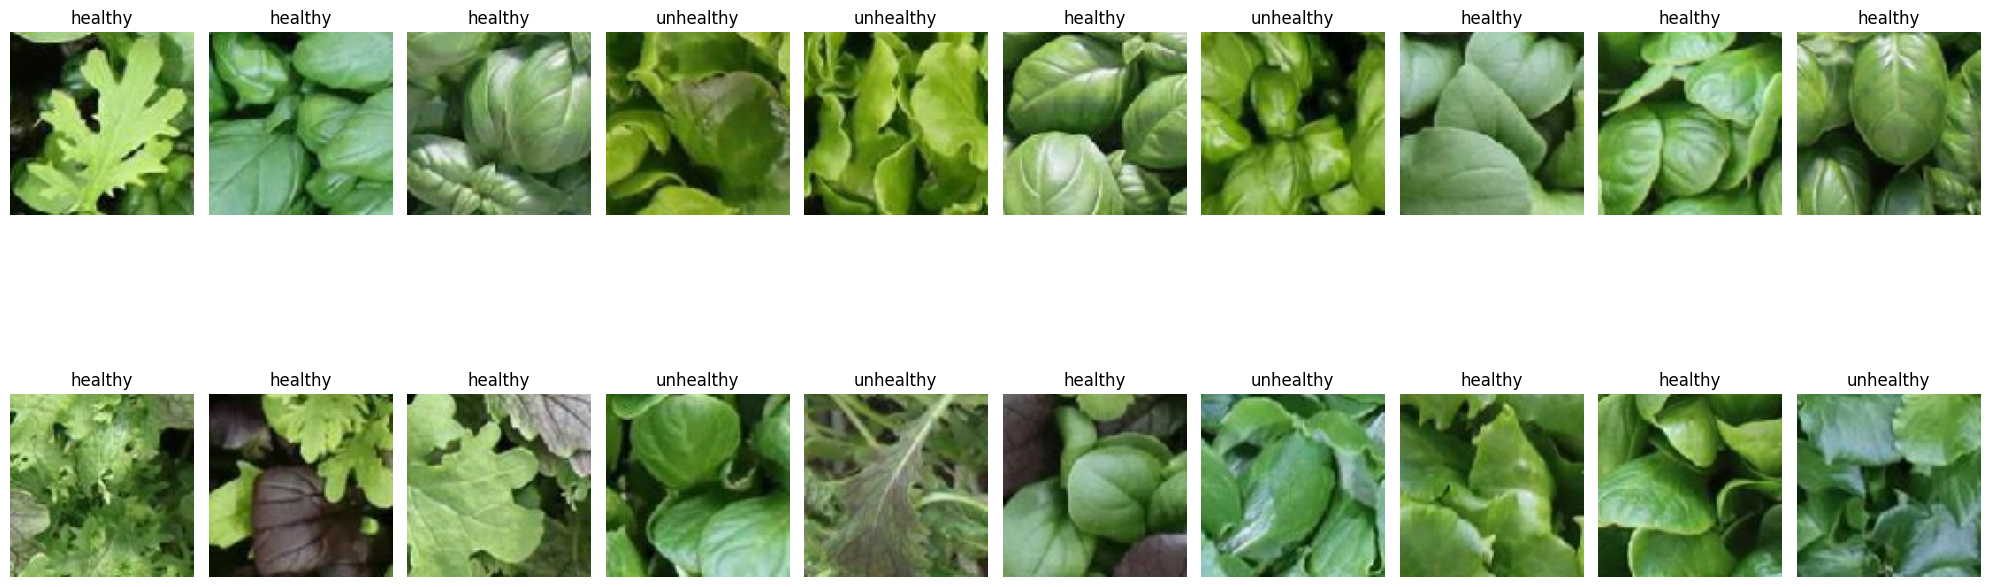

In [149]:
# Visualize first 20 images
n = 20
fig , axes = plt.subplots(int(n/10),10, figsize = (20,9))
axes = axes.reshape((-1,))
for i in range(n):
    axes[i].imshow(np.clip(images[i],0,255))
    axes[i].axis('off')
    axes[i].set_title(labels[i])

plt.tight_layout()

### Clean the dataset

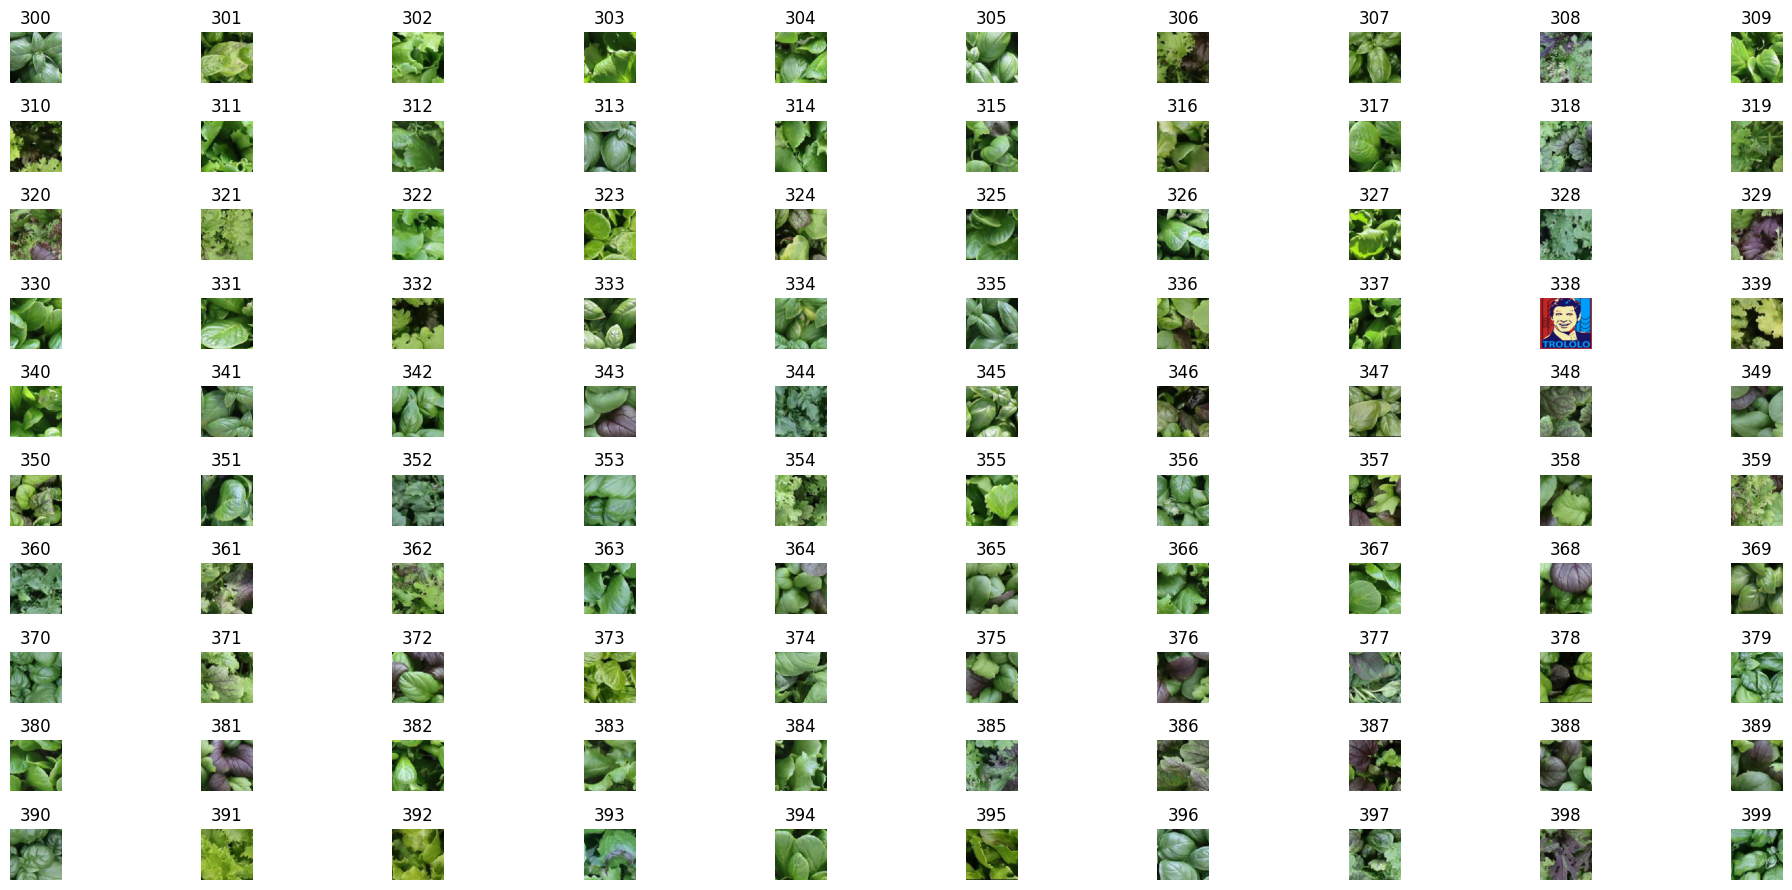

In [150]:
# Visualize interval of 100 images
interval = 3 # first interval -> interval 0
n = 100
fig , axes = plt.subplots(int(n/10),10, figsize = (20,9))
axes = axes.reshape((-1,))
for i in range(n):
    axes[i].imshow(np.clip(images[(interval*n)+i],0,255))
    axes[i].axis('off')
    axes[i].set_title((interval*n)+i)

plt.tight_layout()

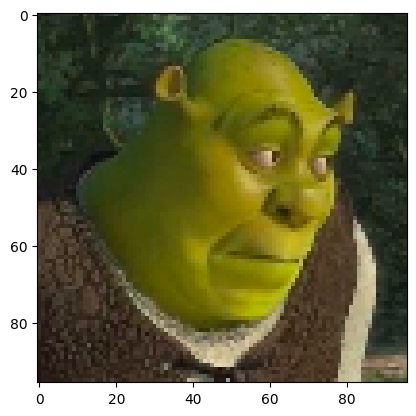

In [151]:
# Save bad images
shrek = images[58]
trololo = images[338]
plt.imshow(np.clip(shrek,0,255))

In [152]:
# Create the mask for bad images
shrek_mask = np.all(images == shrek, axis=(1, 2, 3))
unique_shrek, count_shrek = np.unique(shrek_mask, return_counts= True)
print("There are ", count_shrek[1], " shrek images")

trololo_mask = np.all(images == trololo, axis=(1, 2, 3))
unique_trololo, count_trololo = np.unique(trololo_mask, return_counts= True)
print("and ", count_trololo[1], " trololo images.")

mask_bad = np.logical_or(shrek_mask, trololo_mask)

There are  98  shrek images
and  98  trololo images.


In [153]:
# Delete bad images
images_leaves = images[np.logical_not(mask_bad)]
labels_leaves = labels[np.logical_not(mask_bad)]
print("There are ", len(images_leaves), " leaves images.")

There are  5004  leaves images.


In [154]:
# Find unique images
unique_images, indices_unique_images, count_unique_images = np.unique(images_leaves, return_index= True, return_counts= True, axis= 0)
print("There are ",len(count_unique_images), " unique images.")
images_unique = images_leaves[indices_unique_images]
labels_unique = labels_leaves[indices_unique_images]
labels_unique

There are  4850  unique images.


array(['healthy', 'healthy', 'unhealthy', ..., 'healthy', 'unhealthy',
       'unhealthy'], dtype=object)

In [155]:
# set the definitive dataset
X = images_unique
y = labels_unique

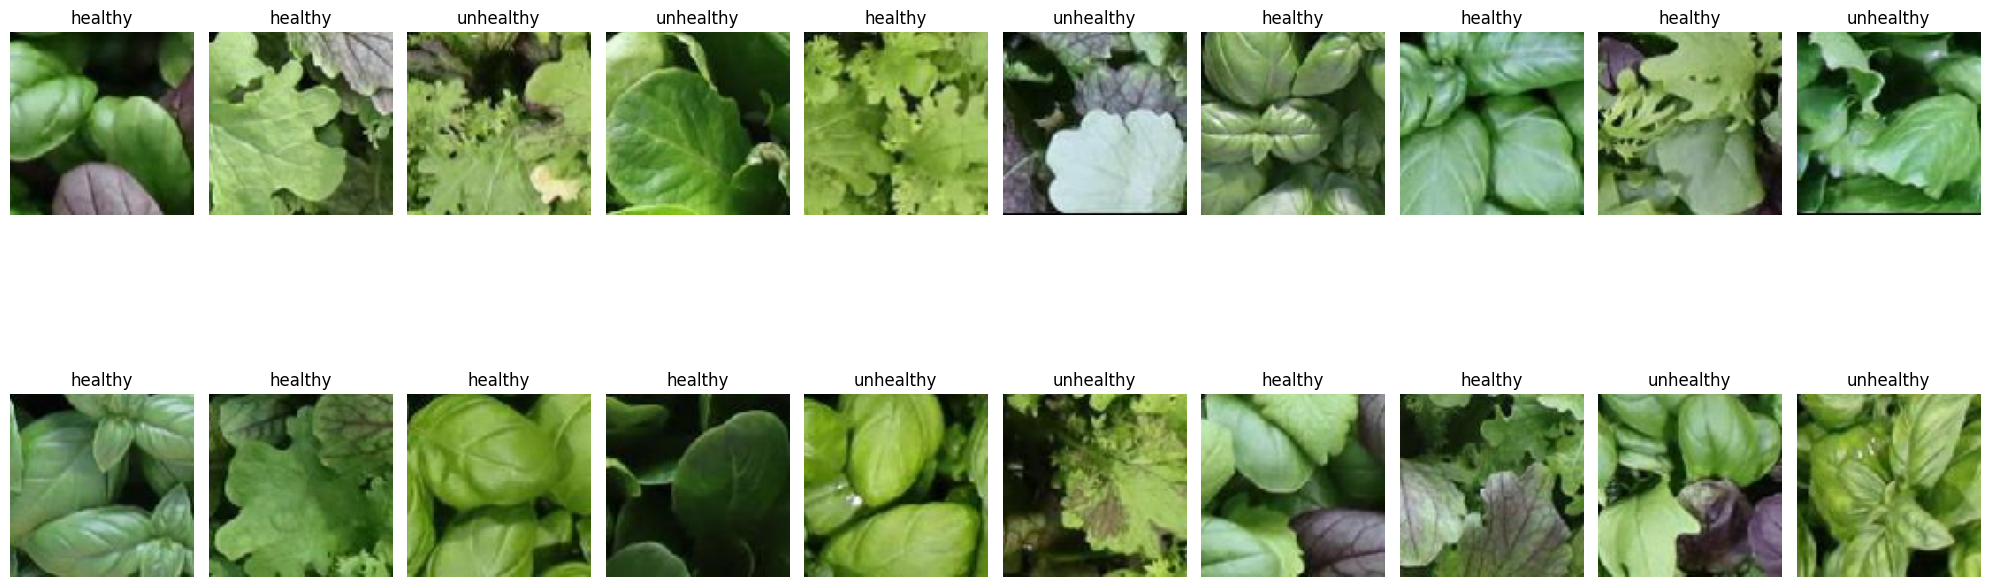

In [156]:
# Visualize first 20 images
n = 20
fig , axes = plt.subplots(int(n/10),10, figsize = (20,9))
axes = axes.reshape((-1,))
for i in range(n):
    axes[i].imshow(np.clip(X[i],0,255))
    axes[i].axis('off')
    axes[i].set_title(y[i])

plt.tight_layout()

(96, 96, 3)

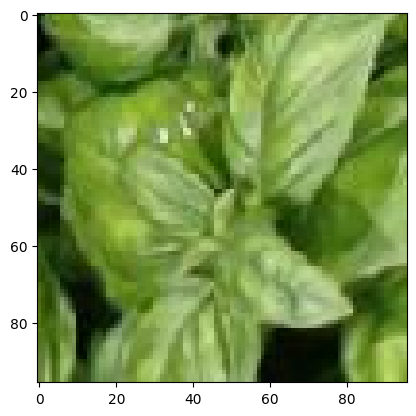

In [157]:
#try to drop green
image = images_unique[19]
plt.imshow(np.clip(image,0,255))
image.shape

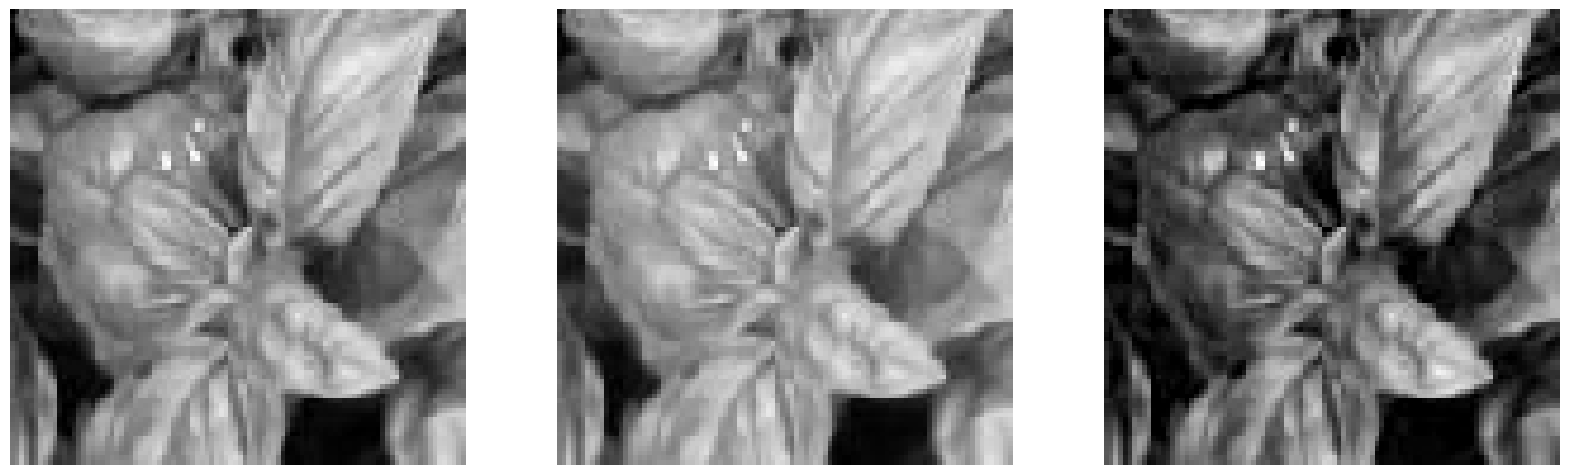

In [158]:
fig , axes = plt.subplots(1,3, figsize = (20,9))
axes = axes.reshape((-1,))
for i in range(3):
    axes[i].imshow(np.clip(image[:,:,i],0,255), cmap= 'gray')
    axes[i].axis('off')
    

### Balance the dataset

In [159]:
uniques, count = np.unique(int_labels, return_counts= True)
N_HEALTHY = count[0]
N_UNHEALTHY = count[1]
N_SAMPLES = N_HEALTHY + N_UNHEALTHY

print("The dataset contains:")
print(N_HEALTHY, " healthy samples")
print(N_UNHEALTHY, " unhealthy samples")
print("For a total of ", N_SAMPLES, " samples")

The dataset contains:
3060  healthy samples
1790  unhealthy samples
For a total of  4850  samples


In [160]:
# Extract the 'unhealthy' images
unhealthy_data = images_unique[labels_unique == 'unhealthy']
unhealthy_labels = labels_unique[labels_unique == 'unhealthy']
unhealthy_data.shape

(1790, 96, 96, 3)

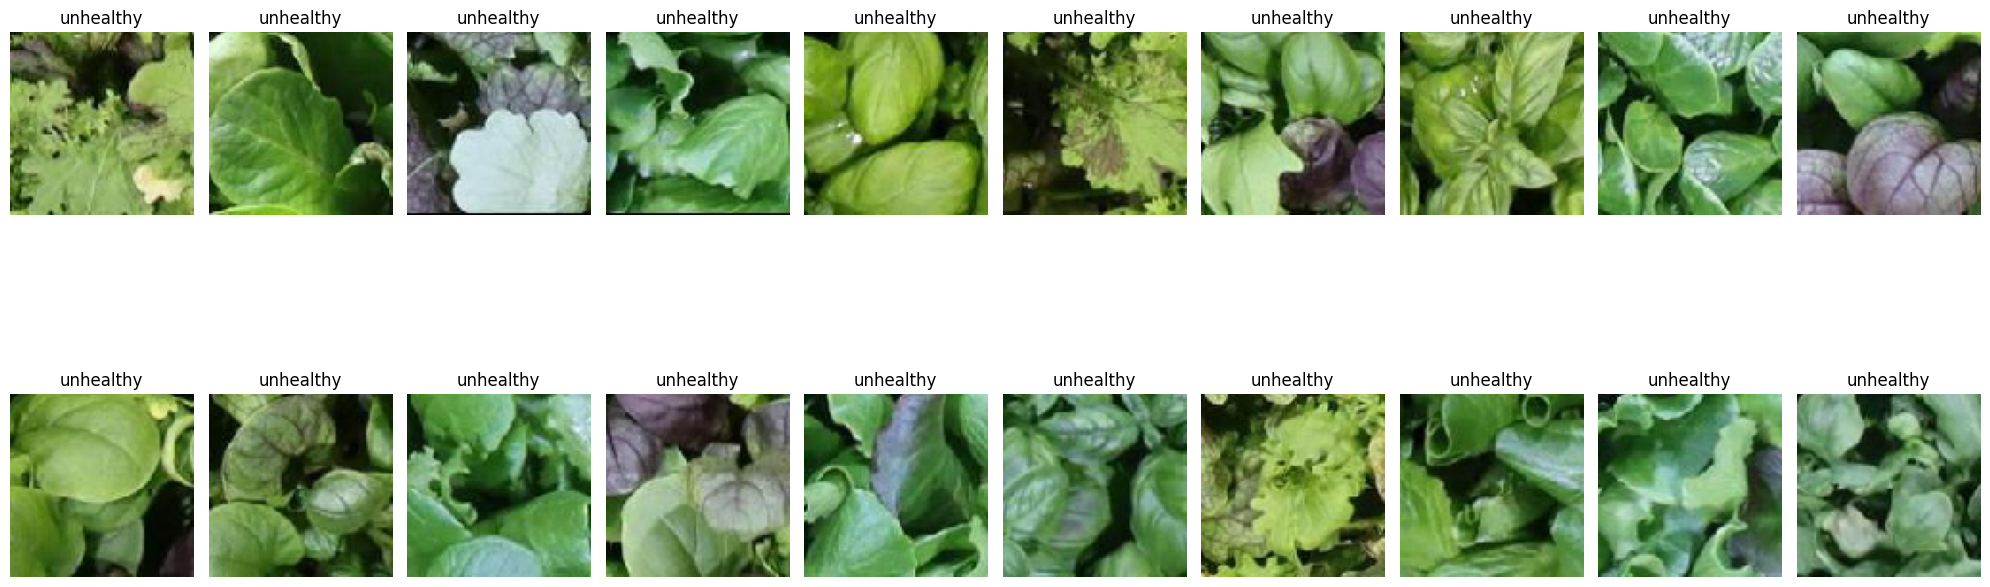

In [161]:
# Visualize first 20 images
n = 20
fig , axes = plt.subplots(int(n/10),10, figsize = (20,9))
axes = axes.reshape((-1,))
for i in range(n):
    axes[i].imshow(np.clip(unhealthy_data[i],0,255))
    axes[i].axis('off')
    axes[i].set_title(unhealthy_labels[i])

plt.tight_layout()

In [162]:
# Compute the ratio between healthy/unhealthy
DIFF = N_HEALTHY-N_UNHEALTHY
DIFF

1270

In [163]:
unhealthy_data.shape

(1790, 96, 96, 3)

In [164]:
# Increase the number of unhealthy by rotating images
from tensorflow.image import rot90

new_unhealthy_data = np.empty((0, 96, 96, 3))

for i in range(DIFF):
    image_idx = random.randint(0, N_UNHEALTHY-1)
    rotation_angle = tf.random.uniform(shape=[], minval=-45, maxval=45, dtype=tf.float32)
    rotated_image = rot90(unhealthy_data[image_idx], k=tf.cast(rotation_angle / 45, dtype=tf.int32))
    rotated_image = tf.expand_dims(rotated_image, axis=0)
    new_unhealthy_data = tf.concat([new_unhealthy_data, rotated_image], axis=0)

In [165]:
# Add label for new unhealthy images
new_unhealthy_labels = np.array(['unhealthy'] * (DIFF))

In [166]:
print(len(new_unhealthy_data))
print(len(new_unhealthy_labels))
print(DIFF)

1270
1270
1270


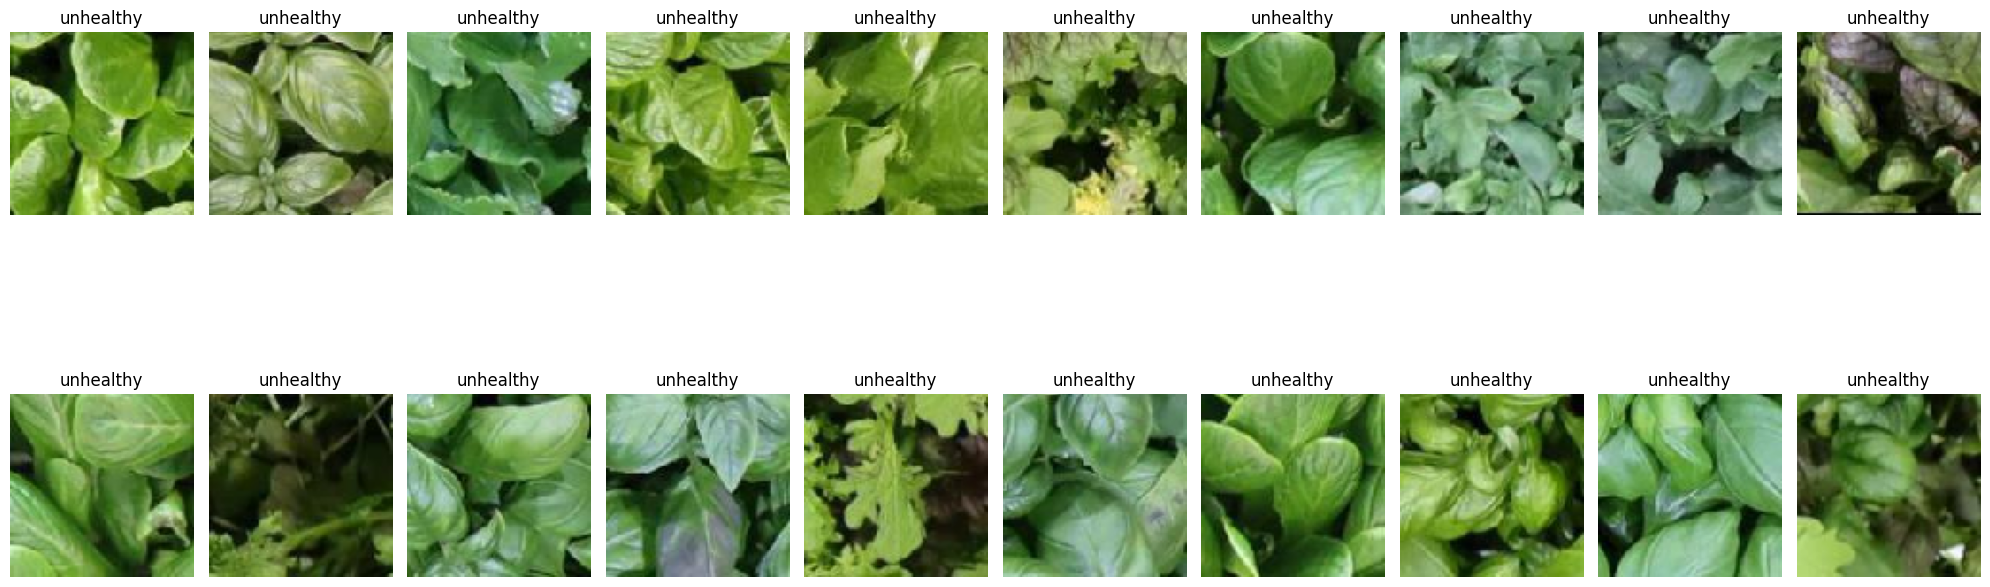

In [167]:
# Visualize last 20 images
n = 20
fig , axes = plt.subplots(int(n/10),10, figsize = (20,9))
axes = axes.reshape((-1,))
for i in range(n):
    axes[i].imshow(np.clip(new_unhealthy_data[-i],0,255))
    axes[i].axis('off')
    axes[i].set_title(new_unhealthy_labels[-i])

plt.tight_layout()

In [180]:
# Add new images to dataset
X = tf.concat([unique_images, new_unhealthy_data], axis=0)
y = tf.concat([labels_unique, new_unhealthy_labels], axis=0)

# Shuffle the data
idxs = np.array(range(len(y)))
random.shuffle(idxs)

X = tf.gather(X, idxs)
y = tf.gather(y, idxs)

In [182]:
unique, count = np.unique(y, return_counts= True)
print("The number of samples is ", len(X))
print("The number of labels is ", len(y))
print("With ", count[0], " ", unique[0].decode(), " samples")
print("and ", count[1], " ", unique[1].decode(), " samples")

The number of samples is  6120
The number of labels is  6120
With  3060   healthy  samples
and  3060   unhealthy  samples


### Create train and validation sets

In [169]:
# Normalize data to the range [0, 1]
X_train_val = (X / 255).astype('float32')

# Create a mapping from label string to values
map = {'healthy':0 , 'unhealthy':1}

# Map labels from string to the corresponding encoding
int_labels = np.array([map[label] for label in y])

In [170]:
# Convert labels to categorical format using one-hot encoding
y_train_val = tfk.utils.to_categorical(int_labels)

In [171]:
# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.1, stratify=y_train_val)

In [172]:
# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)
print("\n")

# Compare categorical label and "default" label representation
print('Categorical label:', y_train[0])           # Display the categorical label
print('"Default" label:', np.argmax(y_train[0]))   # Display the equivalent numeric label

Training Data Shape: (4365, 96, 96, 3)
Training Label Shape: (4365, 2)
Validation Data Shape: (485, 96, 96, 3)
Validation Label Shape: (485, 2)


Categorical label: [1. 0.]
"Default" label: 0


### Augmentation Layer

In [184]:
class CustomAugmentationLayer(tf.keras.layers.Layer):
    def __init__(self, contrast_range=(1.0, 1.4), green_intensity=(0.8, 1.0), brightness_range=0.3, zoom_range=(-0.1, 0.3), shift_range=0.1, crop_range=0.1):
        super(CustomAugmentationLayer, self).__init__()
        self.contrast_range = contrast_range
        self.intensity_range = green_intensity
        self.brightness_range = brightness_range
        self.zoom_range = zoom_range
        self.shift_range = shift_range

    def call(self, inputs, training=None):
        def random_green_intensity(image):
            # Randomly scale the green channel intensity
            scale_factor = tf.random.uniform([], self.intensity_range[0], self.intensity_range[1], dtype=tf.float32)
            red, green, blue = tf.split(image, num_or_size_splits=3, axis=-1)
            image = tf.concat([red, green * scale_factor, blue], axis=-1)
            return image
        
        if training:
            preprocessing = tf.keras.Sequential([
            # Randomly modify contrast and brightness
            tfkl.RandomContrast(self.contrast_range),
            tfkl.RandomBrightness(self.brightness_range),

            # Randomly reduce greens intensity
            tfkl.Lambda(lambda x: random_green_intensity(x)),

            # Randomly apply flip and rotation and translation
            tfkl.RandomFlip(mode= "horizontal_and_vertical"),
            tfkl.RandomRotation(0.25, fill_mode= 'reflect'),
            tfkl.RandomTranslation(self.shift_range, self.shift_range),

            # Randomly apply zoom
            tfkl.RandomZoom(height_factor= self.zoom_range, width_factor= 0.05),

            # Randomly crop
            tfkl.RandomCrop(self.crop_range),
            ], name='preprocessing')

        return preprocessing


## LeNet Model

In [173]:
# Define key model parameters
input_shape = X_train.shape[1:]     # Input shape for the model
output_shape = y_train.shape[1]     # Output shape for the model
batch_size = 128                    # Batch size for training
epochs = 200                        # Number of training epochs

# Print the defined parameters
print("Epochs:\t\t", epochs)
print("Batch Size:\t", batch_size)
print("Input Shape:\t", input_shape)
print("Output Shape:\t", output_shape)

Epochs:		 200
Batch Size:	 128
Input Shape:	 (96, 96, 3)
Output Shape:	 2


In [174]:
def build_LeNet(input_shape, output_shape, seed=seed):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=6,
        kernel_size=(5,5),
        padding='same',
        activation='tanh',
        name='conv1'
    )(input_layer)

    pool1 = tfkl.MaxPooling2D(
        pool_size=(2,2),
        name='mp1'
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=16,
        kernel_size=(5,5),
        padding='valid',
        activation='tanh',
        name='conv2'
    )(pool1)

    pool2 = tfkl.MaxPooling2D(
        pool_size =(2,2),
        name='mp2'
    )(conv2)

    flattening_layer=tfkl.Flatten(
        name='flatten'
    )(pool2)

    classifier_layer=tfkl.Dense(
        units=120,
        activation='tanh',
        name='dense1'
    )(flattening_layer)

    classifier_layer = tfkl.Dense(
        units=84,
        activation='tanh',
        name='dense2'
    )(classifier_layer)

    output_layer = tfkl.Dense(
        units=output_shape,
        activation='softmax',
        name='Output'
    )(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='LeNet')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    # Return the model
    return model

### Training

In [175]:
# Build the LeNet model and display its summary
model = build_LeNet(input_shape, output_shape)
model.summary()

Model: "LeNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 96, 96, 6)         456       
                                                                 
 mp1 (MaxPooling2D)          (None, 48, 48, 6)         0         
                                                                 
 conv2 (Conv2D)              (None, 44, 44, 16)        2416      
                                                                 
 mp2 (MaxPooling2D)          (None, 22, 22, 16)        0         
                                                                 
 flatten (Flatten)           (None, 7744)              0         
                                                                 
 dense1 (Dense)              (None, 120)               929400

In [176]:
# Define early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)

# Train the model and save its history
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
).history

# Save the trained model
model.save('LeNet_CIFAR10')

Epoch 1/200
29/35 [=======================>......] - ETA: 1s - loss: 0.8388 - accuracy: 0.6034

KeyboardInterrupt: 

## MobileNet + Augmentation

In [ ]:
mobile = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)
tfk.utils.plot_model(mobile, show_shapes=True)

In [ ]:
# Use the supernet as feature extractor, i.e. freeze all its weigths
mobile.trainable = False

Build the model and add the fully-connected part

In [ ]:
# Create an input layer with shape (224, 224, 3)
inputs = tfk.Input(shape=(96, 96, 3))

# Connect MobileNetV2 to the input
x = mobile(inputs)

# Add a Dense layer with 2 units and softmax activation as the classifier
intermediate = tfkl.Dense(64, activation='relu')(x)
outputs = tfkl.Dense(2, activation='softmax')(intermediate)

# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
tl_model.summary()

### Training

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input

# Train the model
tl_history = tl_model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,w
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

In [ ]:
# Save the best model
tl_model.save('MobileTransferNoFT_0.82')
del tl_model

In [ ]:
# Save the trained model
model.save("MobileTL+aug")

## Make inference


In [ ]:
# Load the saved residual model
inference_model = tfk.models.load_model('model_name')

In [ ]:
# Predict labels for the entire test set
predictions = inference_model.predict(X_val, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

#print(predictions)

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()